# 크롤링

In [7]:
import os
import urllib
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin

In [ ]:
url = 'https://www.musinsa.com/categories/item/001?d_cat_cd=001&brand=&list_kind=small&sort=pop_category&sub_sort=&page=1&display_cnt=90&group_sale=&exclusive_yn=&sale_goods=&timesale_yn=&ex_soldout=&plusDeliveryYn=&kids=&color=&price1=&price2=&shoeSizeOption=&tags=&campaign_id=&includeKeywords=&measure='
query = urllib.parse.parse_qs(urllib.parse.urlparse(url).query)
df = pd.DataFrame()

In [6]:
def crawling(page=1, category='001'):
    '''
    Init signature:
    crawling(
        page=1,
        category='001'
    ) -> 'DataFrame'
    Docstring:     
    category: '001' = 상의, '002' = 아우터, ...
    '''

    for i in range(1, page+1):
    
        query['page'] = i
        query_url = urllib.parse.urlencode(query, doseq=True)
        base_url = 'https://www.musinsa.com/categories/item/' + category # 001: 상의, 002: 아우터, ...
        url = base_url + '?' + query_url
        
        res = requests.get(url=url)
        dom = BeautifulSoup(res.text, 'html.parser')
        info = dom.select('#searchList > li div.li_inner')
        img = [(_.select('img')[0]['data-original'][:-7] + '500.jpg') if _.select('img')[0]['data-original'].endswith('jpg') else (_.select('img')[0]['data-original'][:-7] + '500.png') for _ in info]
        href = [_.select('a')[0]['href'][2:] for _ in info]
        title = [_.select('a')[0]['title'] for _ in info]
        brand = [_.select('p.item_title > a')[0].text for _ in info]
        price = [_.select('p.price')[0].find('del').decompose() if _.select('p.price')[0].find('del') != None else 0 for _ in info]
        price = [_.select('p.price')[0].text.split()[0] for _ in info]
        df = pd.concat([df, pd.DataFrame([img, href, title, brand, price]).T], axis=0)

    df.rename(columns={0:'이미지', 1:'주소', 2:'제품명', 3:'브랜드', 4:'최종가격'}, inplace=True)
    return df

In [483]:
upper_cloth = crawling(10, '001')
upper_cloth.to_csv('df.csv', index=False)
upper_cloth

,이미지,주소,제품명,브랜드,최종가격
0,https://image.msscdn.net/images/goods_img/2023...,www.musinsa.com/app/goods/3135302,시스루 니트 롱슬리브 커버업_포르테크림,안다르,"27,000원"
1,https://image.msscdn.net/images/goods_img/2022...,www.musinsa.com/app/goods/2406911,커스텀 핏 리넨 셔츠 - 화이트,폴로 랄프 로렌,"239,000원"
2,https://image.msscdn.net/images/goods_img/2023...,www.musinsa.com/app/goods/3591322,트릭 후드 4종 그레이 ISHD6206,펀치라인,"38,900원"
3,https://image.msscdn.net/images/goods_img/2023...,www.musinsa.com/app/goods/3519332,BABY CAT BLESS YOU HOODIE - OATMEAL,잇자바이브,"89,000원"
4,https://image.msscdn.net/images/goods_img/2024...,www.musinsa.com/app/goods/3798771,감탄 레이어드 분또티_White,맨인스토어,"24,900원"
...,...,...,...,...,...
85,https://image.msscdn.net/images/goods_img/2021...,www.musinsa.com/app/goods/2125807,Touch T-shirts,느와,"14,400원"
86,https://image.msscdn.net/images/goods_img/2022...,www.musinsa.com/app/goods/2376224,PAISLEY TAG TEE - WHITE,브라운브레스,"31,200원"
87,https://image.msscdn.net/images/goods_img/2023...,www.musinsa.com/app/goods/3036947,리그 후디 (블루),어반스터프,"79,200원"
88,https://image.msscdn.net/images/goods_img/2022...,www.musinsa.com/app/goods/2407416,로고 반집업 니트 맨투맨 네이비,로열클럽홀리데이,"59,800원"


In [8]:
def download_images(df, folder_path):
    # 폴더가 없으면 생성
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    # 이미지 다운로드
    for i, img_url in enumerate(df['이미지']):
        img_name = 'image_'+ str(i).zfill(4) + '.jpg'
        img_path = os.path.join(folder_path, img_name)
        with open(img_path, 'wb') as f:
            f.write(requests.get(img_url).content)

# 객체 분리

In [80]:
import cv2
import requests
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

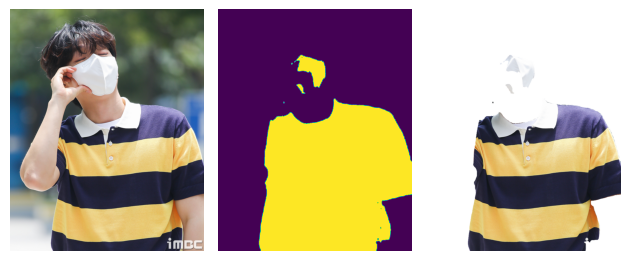

In [83]:
# Segformer 모델과 이미지 프로세서 불러오기
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

# 이미지 URL 가져오기
url = "https://talkimg.imbc.com/TVianUpload/tvian/TViews/image/2021/06/24/9e605fc9-9f16-45a7-ad8d-739590b89d3a.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# 이미지 처리 및 모델 추론
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.cpu()

# 세그멘테이션 결과를 이미지 크기로 업샘플링
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# 가장 높은 확률을 갖는 클래스로 세그멘테이션 결과 생성
pred_seg = upsampled_logits.argmax(dim=1)[0]

# 필요한 라벨의 인덱스 정의
labels_to_keep = [4]  # "Upper-clothes"에 해당하는 라벨 인덱스

# 지정된 라벨만 유지하는 마스크 생성
mask = np.isin(pred_seg.numpy(), labels_to_keep)

# 예측된 세그멘테이션에 마스크 적용
masked_pred_seg = np.where(mask, pred_seg.numpy(), 0)

# 마스킹된 세그멘테이션 표시
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(masked_pred_seg)
# plt.colorbar()
plt.axis('off')

# 상의를 추출
upper_clothes_mask = masked_pred_seg == 4

# 상의 이미지를 원본 이미지에서 추출
upper_clothes_image = np.array(image)
upper_clothes_image[~upper_clothes_mask] = 255  # 상의 영역 이외의 부분을 흰색으로 설정

# 상의 이미지 출력
plt.subplot(1,3,3)
plt.imshow(upper_clothes_image)
plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
upper_clothes_image = cv2.cvtColor(upper_clothes_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('upper_clothes.png', upper_clothes_image)

True

# 수집한 데이터 EDA

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
target_folder = "./상의_사진"
img_list = os.listdir(target_folder)

"""
각 이미지 시계열에서 확인할 자료들
file_name: 이미지 파일 이름
seq_len: 이미지 시계열 길이
img_row: 이미지 가로 길이
img_col: 이미지 세로 길이
RGB: 이미지에서 RGB 채널 각각의 최대, 최소, 중앙값, 평균, 표준편차
"""

df_EDA = pd.DataFrame(columns=["file_name", "seq_len", "img_row", "img_col",
                               "R_min", "R_median", "R_max", "G_min", "G_median", "G_max",
                               "B_min", "B_median", "B_max", "R_mean", "R_std", "G_mean",
                               "G_std", "B_mean", "B_std"
                               ])

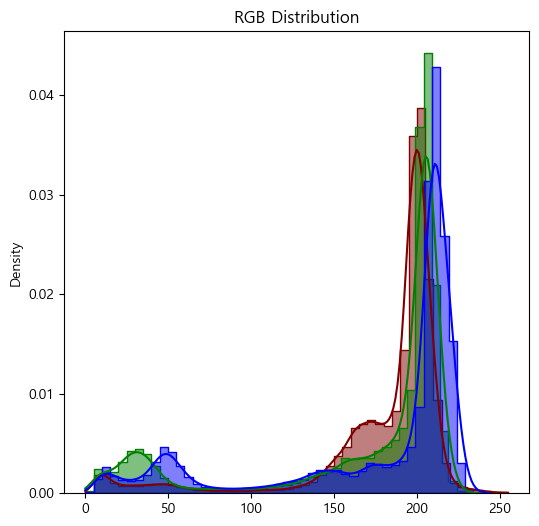

In [66]:
for i in range(len(folder_list)):
    new_row = [folder_list[i]]
    new_row.append(len(img_list))
    test_img = np.asarray(plt.imread("./{0}".format(img_list[0])))
    new_row += [test_img.shape[0], test_img.shape[1]]
    r_seq = test_img[:, :, 0].flatten()
    g_seq = test_img[:, :, 1].flatten()
    b_seq = test_img[:, :, 2].flatten()
    if i % 1000 == 0:
        # 1000개 단위로 이미지의 RGB 채널 분포를 그리는 코드
        plt.figure(figsize=(6, 6))
        sns.histplot(r_seq, color='maroon', kde=True, stat='density', binwidth=5,  element="step")
        sns.histplot(g_seq, color='green', kde=True, stat='density', binwidth=5,  element="step")
        sns.histplot(b_seq, color='blue', kde=True, stat='density', binwidth=5, element="step").set_title("RGB Distribution")
        # plt.tight_layout()

    color = [np.min(r_seq), np.median(r_seq), np.max(r_seq),
             np.min(g_seq), np.median(g_seq), np.max(g_seq),
             np.min(b_seq), np.median(b_seq), np.max(b_seq),
             np.mean(r_seq), np.std(r_seq), np.mean(g_seq),
             np.std(g_seq), np.mean(b_seq), np.std(b_seq)]
    # 얻은 정보를 데이터프레임에 추가
    df_EDA.loc[i] = new_row + color

In [55]:
df_EDA.describe()

,seq_len,img_row,img_col,R_min,R_median,R_max,G_min,G_median,G_max,B_min,B_median,B_max,R_mean,R_std,G_mean,G_std,B_mean,B_std
count,775.0,775.0,775.0,775.0,775.0,775.0,775.0,775.0,775.0,775.0,775.0,775.0,7.750000e+02,7.750000e+02,7.750000e+02,7.750000e+02,7.750000e+02,7.750000e+02
mean,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.834811e-13,5.901313e-13,2.303645e-12,4.052709e-13,5.688013e-13,1.990804e-13
min,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01
25%,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01
50%,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01
75%,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01
max,775.0,600.0,500.0,0.0,196.0,255.0,0.0,202.0,239.0,0.0,209.0,244.0,1.796055e+02,4.440919e+01,1.688877e+02,6.268771e+01,1.753685e+02,6.266770e+01


# 이미지 유사도

In [73]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms

In [74]:
# 이미지를 불러오고 특징 벡터로 변환하는 함수
def image_to_feature_vector(image_path, model, device):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature_vector = model(image_tensor)
    return feature_vector

# 이미지 유사도를 계산하는 함수
def compute_image_similarity(image_feature1, image_feature2):
    return F.cosine_similarity(image_feature1, image_feature2).item()

In [77]:
# 상의 이미지의 경로 설정
upper_clothes_image_path = r'./upper_clothes.png'

# 미리 훈련된 ResNet 모델 불러오기
resnet_model = models.resnet50(weights=True)  # 변경
resnet_model.fc = nn.Identity()
resnet_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# ResNet18 모델
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=True)
# resnet_model.fc = nn.Identity()
# resnet_model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet_model.to(device)

# 상의 이미지의 특징 벡터 추출
upper_clothes_feature_vector = image_to_feature_vector(upper_clothes_image_path, resnet_model, device)

# 크롤링한 상의 이미지들과의 유사도 계산
folder_path = r'./상의_사진/'

image_similarity_scores = []

for image_file in os.listdir(folder_path):
    image_path = os.path.join(folder_path, image_file)
    image_feature_vector = image_to_feature_vector(image_path, resnet_model, device)
    similarity = compute_image_similarity(upper_clothes_feature_vector, image_feature_vector)
    image_similarity_scores.append((image_path, similarity))

# 유사도를 기준으로 상위 10개 이미지를 선택
top_10_similar_images = sorted(image_similarity_scores, key=lambda x: x[1], reverse=True)[:10]

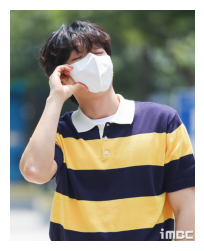

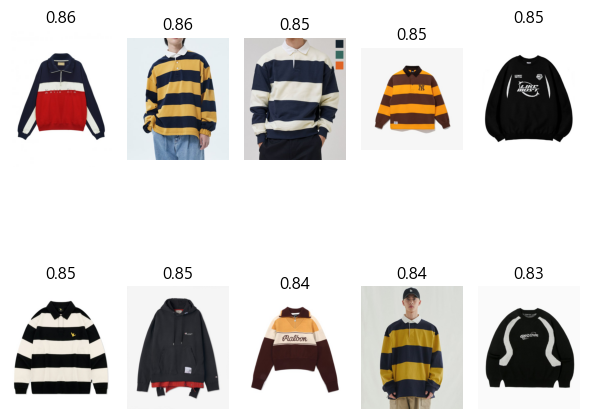

In [84]:
# 상위 10개 이미지 출력
similar_images = [_[0] for _ in top_10_similar_images]

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')

plt.figure(figsize=(6, 6))
for i in range(10):  
    plt.subplot(2, 5, i+1)
    plt.imshow(plt.imread(similar_images[i]))
    plt.title(f'{top_10_similar_images[i][1]:.2f}')
    plt.axis('off')
plt.tight_layout()

Text(0.5, 1.0, 'RGB Distribution')

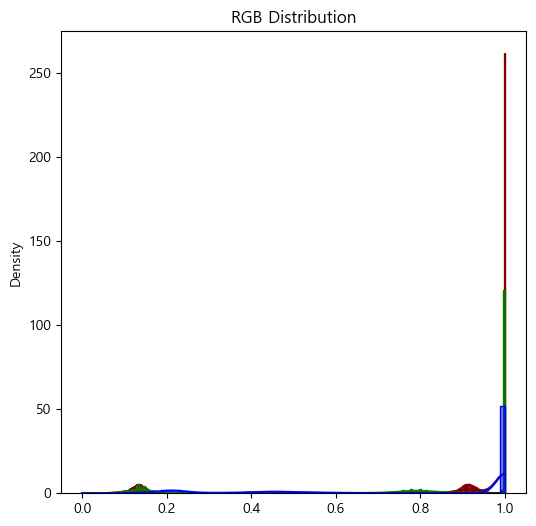

In [114]:
test_img = np.asarray(plt.imread('upper_clothes.png'))
new_row += [test_img.shape[0], test_img.shape[1]]
r_seq = test_img[:, :, 0].flatten()
g_seq = test_img[:, :, 1].flatten()
b_seq = test_img[:, :, 2].flatten()

plt.figure(figsize=(6, 6))
sns.histplot(r_seq, color='maroon', kde=True, stat='density', element="step")
sns.histplot(g_seq, color='green', kde=True, stat='density', element="step")
sns.histplot(b_seq, color='blue', kde=True, stat='density', element="step").set_title("RGB Distribution")

In [140]:
plt.imread(top_10_similar_images[1][0])
plt.imread(top_10_similar_images[1][0]).shape

(600, 500, 3)

Text(0.5, 1.0, 'RGB Distribution')

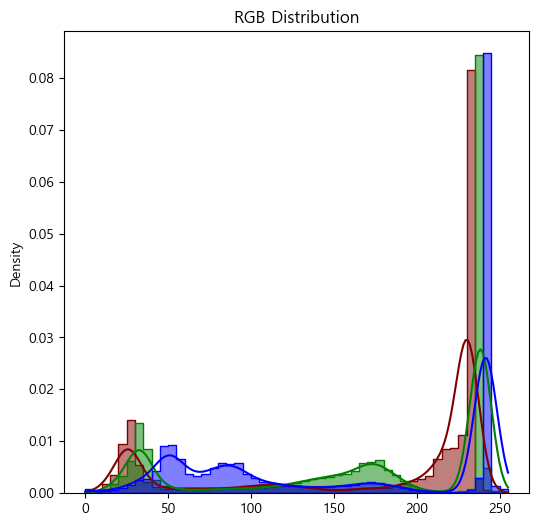

In [94]:
test_img = np.asarray(plt.imread(top_10_similar_images[1][0]))
new_row += [test_img.shape[0], test_img.shape[1]]
r_seq = test_img[:, :, 0].flatten()
g_seq = test_img[:, :, 1].flatten()
b_seq = test_img[:, :, 2].flatten()

plt.figure(figsize=(6, 6))
sns.histplot(r_seq, color='maroon', kde=True, stat='density', binwidth=5,  element="step")
sns.histplot(g_seq, color='green', kde=True, stat='density', binwidth=5,  element="step")
sns.histplot(b_seq, color='blue', kde=True, stat='density', binwidth=5, element="step").set_title("RGB Distribution")

In [95]:
color = [np.min(r_seq), np.median(r_seq), np.max(r_seq),
         np.min(g_seq), np.median(g_seq), np.max(g_seq),
         np.min(b_seq), np.median(b_seq), np.max(b_seq),
         np.mean(r_seq), np.std(r_seq), np.mean(g_seq),
         np.std(g_seq), np.mean(b_seq), np.std(b_seq)]
color

[0,
 222.0,
 255,
 0,
 185.0,
 255,
 0,
 172.0,
 255,
 170.65042,
 82.45913711544404,
 167.75406333333333,
 79.92218560464083,
 157.65001333333333,
 84.12787692554603]